In [252]:
using Gadfly

In [303]:
using DataFrames, CSV
ntd_df = CSV.read("ntd_2023.csv", DataFrame);
us_census_df = CSV.read("us_census_2020.csv", DataFrame);

In [306]:
@from row in ntd_df begin
    @where row.uza_name == "New York--Jersey City--Newark, NY--NJ"
    @select row
    @collect DataFrame
end

Row,agency,city,state,ntd_id,organization_type,reporter_type,report_year,uace_code,uza_name,primary_uza_population,agency_voms,mode,mode_name,type_of_service,mode_voms,fare_revenues_per_unlinked,fare_revenues_per_unlinked_1,fare_revenues_per_total,fare_revenues_per_total_1,cost_per_hour,cost_per_hour_questionable,passengers_per_hour,passengers_per_hour_1,cost_per_passenger,cost_per_passenger_1,cost_per_passenger_mile,cost_per_passenger_mile_1,fare_revenues_earned,fare_revenues_earned_1,total_operating_expenses,total_operating_expenses_1,unlinked_passenger_trips,unlinked_passenger_trips_1,vehicle_revenue_hours,vehicle_revenue_hours_1,passenger_miles,passenger_miles_questionable,vehicle_revenue_miles,vehicle_revenue_miles_1
,String,String31?,String3,Int64,String,String31,Int64,Int64?,String?,Int64?,Int64,String3,String31,String3,Int64,Float64,String1?,Float64,Missing,Float64,String1?,Float64,String1?,Float64,String1?,Float64,String1?,Int64,Missing,Int64,Missing,Int64,String1?,Int64,String1?,Int64,String1?,Int64,String1?
1,City of Long Beach,Long Beach,NY,20006,"City, County or Local Government Unit or Department of Transportation",Full Reporter,2023,63217,"New York--Jersey City--Newark, NY--NJ",19426449,7,MB,Bus,DO,5,2.2084,missing,0.069,missing,123.179,missing,3.8488,missing,32.0042,missing,11.4358,missing,206715,missing,2995718,missing,93604,missing,24320,missing,261959,missing,224138,missing
2,City of Long Beach,Long Beach,NY,20006,"City, County or Local Government Unit or Department of Transportation",Full Reporter,2023,63217,"New York--Jersey City--Newark, NY--NJ",19426449,7,DR,Demand Response,DO,2,0.9957,missing,0.0044,missing,270.178,missing,1.189,missing,227.228,missing,103.535,missing,3902,missing,890507,missing,3919,missing,3296,missing,8601,missing,8531,missing
3,MTA New York City Transit,Brooklyn,NY,20008,"Subsidiary Unit of a Transit Agency, Reporting Separately",Full Reporter,2023,63217,"New York--Jersey City--Newark, NY--NJ",19426449,10040,RB,Bus Rapid Transit,DO,123,0.6412,missing,0.1811,missing,250.006,missing,70.6302,missing,3.5396,missing,2.0292,missing,20380061,missing,112504538,missing,31784162,missing,450008,missing,55443548,missing,2979357,missing
4,MTA New York City Transit,Brooklyn,NY,20008,"Subsidiary Unit of a Transit Agency, Reporting Separately",Full Reporter,2023,63217,"New York--Jersey City--Newark, NY--NJ",19426449,10040,HR,Heavy Rail,DO,5384,1.34,missing,0.4471,missing,280.357,missing,93.5404,missing,2.9972,missing,0.7558,missing,2703907746,missing,6047953647,missing,2017881703,missing,21572297,missing,8001949426,missing,343813756,missing
5,MTA New York City Transit,Brooklyn,NY,20008,"Subsidiary Unit of a Transit Agency, Reporting Separately",Full Reporter,2023,63217,"New York--Jersey City--Newark, NY--NJ",19426449,10040,MB,Bus,DO,3214,0.9914,missing,0.1814,missing,262.503,missing,48.0333,missing,5.465,missing,2.2707,missing,565695988,missing,3118485221,missing,570625248,missing,11879789,missing,1373347948,missing,83176381,missing
6,MTA New York City Transit,Brooklyn,NY,20008,"Subsidiary Unit of a Transit Agency, Reporting Separately",Full Reporter,2023,63217,"New York--Jersey City--Newark, NY--NJ",19426449,10040,DR,Demand Response,PT,876,1.8914,missing,0.0091,missing,248.171,missing,1.194,missing,207.856,missing,22.7655,missing,5138039,missing,564652967,missing,2716563,missing,2275256,missing,24803017,missing,22534535,missing
7,MTA New York City Transit,Brooklyn,NY,20008,"Subsidiary Unit of a Transit Agency, Reporting Separately",Full Reporter,2023,63217,"New York--Jersey City--Newark, NY--NJ",19426449,10040,CB,Commuter Bus,DO,443,5.7331,missing,0.1811,missing,471.605,missing,14.8968,missing,31.6582,missing,2.0984,missing,51571661,missing,284777119,missing,8995368,missing,603847,missing,135709719,missing,9699486,missing
8,"Town of Huntington, dba: Huntington Area Rapid Transit",Huntington,NY,20071,"City, County or Local Government Unit or Department of Transportation",Full Reporter,2023,63217,"N

In [382]:
metro_areas1 = [
    "New York--Jersey City--Newark, NY--NJ"
    "Los Angeles--Long Beach--Anaheim, CA"
    "Chicago, IL--IN"
    "Miami--Fort Lauderdale, FL"
    "Houston, TX"
    "Dallas--Fort Worth--Arlington, TX"
]
metro_areas2 = [
    "Philadelphia, PA--NJ--DE--MD"
    "Washington--Arlington, DC--VA--MD"
    "Atlanta, GA"
    "Boston, MA--NH"
    "Seattle--Tacoma, WA"
    "San Francisco--Oakland, CA"
    "San Diego, CA"
];

parsed = @from ntd_row in ntd_df begin
    @where ntd_row.primary_uza_population >= 0
    @join area in metro_areas1 on ntd_row.uza_name[] equals area
    @group ntd_row by ntd_row.uza_name into g
    @join census_row in us_census_df on key(g) equals census_row[2] into x
    @let population = first(g.primary_uza_population)
    @let land_area = sum(map(c -> parse(Int64,replace(c[7][], r","=>"")), x))
    @let metro_area=key(g)[]
    @select {
        metro_area,
        name=metro_area[1:findfirst(c -> c == ',' || c == '-', metro_area)-1],
        rides_per_capita=sum(g.unlinked_passenger_trips ./ g.primary_uza_population),
        population,
        population_density=population / (land_area / 1000^2),
        country=:us
    }
    @collect DataFrame
end

append!(parsed, @from ntd_row in ntd_df begin
    @where ntd_row.primary_uza_population >= 0
    @join area in metro_areas2 on ntd_row.uza_name[] equals area
    @group ntd_row by ntd_row.uza_name into g
    @join census_row in us_census_df on key(g) equals census_row[2] into x
    @let population = first(g.primary_uza_population)
    @let land_area = sum(map(c -> parse(Int64,replace(c[7][], r","=>"")), x))
    @let metro_area=key(g)[]
    @select {
        metro_area,
        name=metro_area[1:findfirst(c -> c == ',' || c == '-', metro_area)-1],
        rides_per_capita=sum(g.unlinked_passenger_trips ./ g.primary_uza_population),
        population,
        population_density=population / (land_area / 1000^2),
        country=:canada
    }
    @collect DataFrame
end)

Row,metro_area,name,rides_per_capita,population,population_density,country
,String,String,Float64?,Int64?,Float64?,Symbol
1,"New York--Jersey City--Newark, NY--NJ",New York,167.116,19426449,2309.21,us
2,"Miami--Fort Lauderdale, FL",Miami,18.9409,6077522,1886.02,us
3,"Chicago, IL--IN",Chicago,38.3212,8671746,1432.14,us
4,"Dallas--Fort Worth--Arlington, TX",Dallas,9.74154,5732354,1266.98,us
5,"Houston, TX",Houston,11.7942,5853575,1289.49,us
6,"Los Angeles--Long Beach--Anaheim, CA",Los Angeles,31.7221,12237376,2886.61,us
7,"Seattle--Tacoma, WA",Seattle,43.0793,3544011,1392.7,canada
8,"Boston, MA--NH",Boston,54.9247,4382009,1021.75,canada
9,"Philadelphia, PA--NJ--DE--MD",Philadelphia,37.1115,5696125,1158.62,canada


In [386]:
transit_agencies1 = [
    "MTA New York City Transit"
    "Los Angeles County Metropolitan Transportation Authority , dba: Metro"
    "Chicago Transit Authority"
    "County of Miami-Dade"
    "Metropolitan Transit Authority of Harris County, Texas , dba: METRO"
    "Dallas Area Rapid Transit"
]
transit_agencies2 = [
    "Southeastern Pennsylvania Transportation Authority"
    "Washington Metropolitan Area Transit Authority, dba: Washington Metro"
    "Metropolitan Atlanta Rapid Transit Authority"
    "Massachusetts Bay Transportation Authority"
    "King County, dba: King County Metro"
    "City and County of San Francisco, dba: San Francisco Municipal Transportation Agency"
    "San Diego Metropolitan Transit System"
];

parsed2 = @from ntd_row in ntd_df begin
    @where ntd_row.primary_uza_population >= 0
    @join agency in transit_agencies1 on ntd_row.agency equals agency
    @group ntd_row by ntd_row.uza_name into g
    @join census_row in us_census_df on key(g) equals census_row[2] into x
    @let population = first(g.primary_uza_population)
    @let land_area = sum(map(c -> parse(Int64,replace(c[7][], r","=>"")), x))
    @let metro_area=key(g)[]
    @select {
        metro_area,
        name=metro_area[1:findfirst(c -> c == ',' || c == '-', metro_area)-1],
        rides_per_capita=sum(g.unlinked_passenger_trips ./ g.primary_uza_population),
        population,
        population_density=population / (land_area / 1000^2),
        passenger_miles=sum(g.passenger_miles),
        operating_cost=sum(g.total_operating_expenses),
        efficiency=sum(g.passenger_miles)/sum(g.total_operating_expenses),
        country=:us
    }
    @collect DataFrame
end

append!(parsed2, @from ntd_row in ntd_df begin
    @where ntd_row.primary_uza_population >= 0
    @join agency in transit_agencies2 on ntd_row.agency equals agency
    @group ntd_row by ntd_row.uza_name into g
    @join census_row in us_census_df on key(g) equals census_row[2] into x
    @let population = first(g.primary_uza_population)
    @let land_area = sum(map(c -> parse(Int64,replace(c[7][], r","=>"")), x))
    @let metro_area=key(g)[]
    @select {
        metro_area,
        name=metro_area[1:findfirst(c -> c == ',' || c == '-', metro_area)-1],
        rides_per_capita=sum(g.unlinked_passenger_trips ./ g.primary_uza_population),
        population,
        population_density=population / (land_area / 1000^2),
        passenger_miles=sum(g.passenger_miles),
        operating_cost=sum(g.total_operating_expenses),
        efficiency=sum(g.passenger_miles)/sum(g.total_operating_expenses),
        country=:canada
    }
    @collect DataFrame
end)

Row,metro_area,name,rides_per_capita,population,population_density,passenger_miles,operating_cost,efficiency,country
,String,String,Float64?,Int64?,Float64?,Int64,Int64,Float64,Symbol
1,"New York--Jersey City--Newark, NY--NJ",New York,135.486,19426449,2309.21,9591253658,10128373492,0.946969,us
2,"Miami--Fort Lauderdale, FL",Miami,12.8279,6077522,1886.02,414128978,702799047,0.589257,us
3,"Chicago, IL--IN",Chicago,32.1903,8671746,1432.14,1090677628,1696315817,0.642968,us
4,"Houston, TX",Houston,11.7152,5853575,1289.49,394716905,795077056,0.496451,us
5,"Dallas--Fort Worth--Arlington, TX",Dallas,8.50199,5732354,1266.98,283376221,676837132,0.418677,us
6,"Los Angeles--Long Beach--Anaheim, CA",Los Angeles,22.5786,12237376,2886.61,1190726684,2196624387,0.542071,us
7,"Seattle--Tacoma, WA",Seattle,22.2592,3544011,1392.7,301530502,928694623,0.324682,canada
8,"Boston, MA--NH",Boston,53.6228,4382009,1021.75,1103417623,1890926712,0.583533,canada
9,"Philadelphia, PA--NJ--DE--MD",Philadelphia,34.6314,5696125,1158.62,834809485,1442624575,0.578674,canada


In [379]:
using GLM

ols = lm(@formula(passenger_miles ~ operating_cost), parsed2)
coef(ols)

2-element Vector{Float64}:
 0.0
 0.49018461204765595

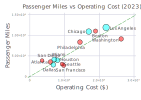

In [383]:
p1 = plot(parsed, x=:population_density, y=:rides_per_capita, size=:population, label=:name, color=:country, alpha=[.5],
    Scale.size_area((p; min=.5mm, max=4mm) -> min + p*(max-min), minvalue=minimum(parsed.population), maxvalue=maximum(parsed.population)),
    Scale.color_discrete_manual(colorant"aqua", colorant"red"),
    Guide.xlabel("Population Density (people per square kilometer)"),
    Guide.ylabel("Rides Per Capita"),
    Guide.title("Rides Per Capita vs Population Density (2023)"),
    Guide.xticks(ticks=(1:6)*500),
    Geom.point,
    Geom.label(position=:dynamic, hide_overlaps=false),
    Coord.cartesian(xmin=500),
    Theme(key_position=:none, grid_line_width=.5mm, grid_line_style=:solid, point_label_font_size=12pt, major_label_font_size=16pt, discrete_highlight_color=x->"black")
)
p2 = plot(parsed2, x=:population_density, y=:rides_per_capita, size=:population, label=:name, color=:country, alpha=[.5],
    Scale.size_area((p; min=.5mm, max=4mm) -> min + p*(max-min), minvalue=minimum(parsed.population), maxvalue=maximum(parsed.population)),
    Scale.color_discrete_manual(colorant"aqua", colorant"red"),
    Guide.xlabel("Population Density (people per square kilometer)"),
    Guide.ylabel("Rides Per Capita"),
    Guide.title("Rides Per Capita vs Population Density (2023)"),
    Guide.xticks(ticks=(1:6)*500),
    Geom.point,
    Geom.label(position=:dynamic, hide_overlaps=false),
    Coord.cartesian(xmin=500),
    Theme(key_position=:none, grid_line_width=.5mm, grid_line_style=:solid, point_label_font_size=12pt, major_label_font_size=16pt, discrete_highlight_color=x->"black")
)
p3 = plot(parsed2, x=:operating_cost, y=:passenger_miles, size=:population, label=:name, color=:country, alpha=[.5],
    Scale.size_area((p; min=.5mm, max=4mm) -> min + p*(max-min), minvalue=minimum(parsed.population), maxvalue=maximum(parsed.population)),
    Scale.color_discrete_manual(colorant"aqua", colorant"red"),
    Guide.xlabel("Operating Cost (\$)"),
    Guide.ylabel("Passenger Miles"),
    Guide.title("Passenger Miles vs Operating Cost (2023)"),
    Geom.point,
    Geom.label(position=:dynamic, hide_overlaps=false),
    intercept=[coef(ols)[1]],
    slope=[coef(ols)[2]],
    Geom.abline(color="green", style=:dash),
    Theme(key_position=:none, grid_line_width=.5mm, grid_line_style=:solid, point_label_font_size=12pt, major_label_font_size=16pt, discrete_highlight_color=x->"black")
)

In [384]:
p1 |> SVG("rides_per_cap_vs_pop_density.svg", 8inch, 5inch)

false